In [59]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [60]:
random.seed(42)

In [61]:
def day_weather_state():
    r = random.random()
    if r < 0.6:
        return "clear"
    elif r < 0.85:
        return "partly"
    else:
        return "cloudy"


# weather-state model → best for yearly/weekly studies with “realistic” cloudy vs sunny distributions.
def weather_factor(state):
    if state == "clear": return random.uniform(0.9, 1.0)
    if state == "partly": return random.uniform(0.4, 0.8)
    if state == "cloudy": return random.uniform(0.1, 0.3)

In [62]:
def solar_power_estimate(
    n, t_solar, latitude, tilt, azimuth,
    area=1.6,
    eta_ref=0.18,
    alpha_T=-0.004,
    NOCT=45,
    T_amb=25,
    rho_g=0.2,
    k=0.14
):
    G_sc = 1367  # solar constant

    # declination
    delta = math.radians(23.45 * math.sin(math.radians(360 * (284 + n) / 365)))

    # latitude etc.
    phi = math.radians(latitude)
    beta = math.radians(tilt)
    gamma_p = math.radians(azimuth)
    omega = math.radians(15 * (t_solar - 12))

    # zenith angle
    cos_theta_z = math.sin(phi) * math.sin(delta) + math.cos(phi) * math.cos(delta) * math.cos(omega)
    if cos_theta_z <= 0:
        return 0.0

    # incidence angle
    cos_theta = (
        math.sin(delta) * math.sin(phi) * math.cos(beta)
        - math.sin(delta) * math.cos(phi) * math.sin(beta) * math.cos(gamma_p)
        + math.cos(delta) * math.cos(phi) * math.cos(beta) * math.cos(omega)
        + math.cos(delta) * math.sin(phi) * math.sin(beta) * math.cos(gamma_p) * math.cos(omega)
        + math.cos(delta) * math.sin(beta) * math.sin(gamma_p) * math.sin(omega)
    )
    cos_theta = max(0, cos_theta)

    # extraterrestrial irradiance
    E0 = 1 + 0.033 * math.cos(math.radians(360 * n / 365))
    G0 = G_sc * E0

    # clear-sky attenuation
    AM = 1 / cos_theta_z
    G_b = G0 * math.exp(-k * AM)
    G_b_horizontal = G_b * cos_theta_z

    # diffuse assumption
    G_d = 0.15 * (G_b_horizontal / cos_theta_z)
    G_h = G_b_horizontal + G_d

    # tilt adjustments
    G_b_tilt = G_b * cos_theta
    G_d_tilt = G_d * (1 + math.cos(beta)) / 2
    G_r = G_h * rho_g * (1 - math.cos(beta)) / 2
    G_POA = G_b_tilt + G_d_tilt + G_r

    # cell temp & efficiency
    T_cell = T_amb + (NOCT - 20) / 800 * G_POA
    eta = eta_ref * (1 + alpha_T * (T_cell - 25))
    return max(G_POA * area * eta, 0.0)

In [63]:
def plot_daily_curve(n, latitude, tilt=30, azimuth=0, area=1.6, **kwargs):
    hours = np.linspace(0, 24, 145)  # every 10 minutes
    power = [solar_power_estimate(n, h, latitude, tilt, azimuth, area=area, **kwargs) for h in hours]

    plt.figure(figsize=(8,4))
    plt.plot(hours, power, label="Panel Power (W)")
    plt.title(f"Daily Power Curve (Day {n}, lat {latitude}°)")
    plt.xlabel("Solar Time (hours)")
    plt.ylabel("Power (W)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [64]:
area = 0.248213  # from Panasonic AM-5608CAR solar panel
eta_ref=0.0005  # 0.05% efficiency for testing low power scenarios

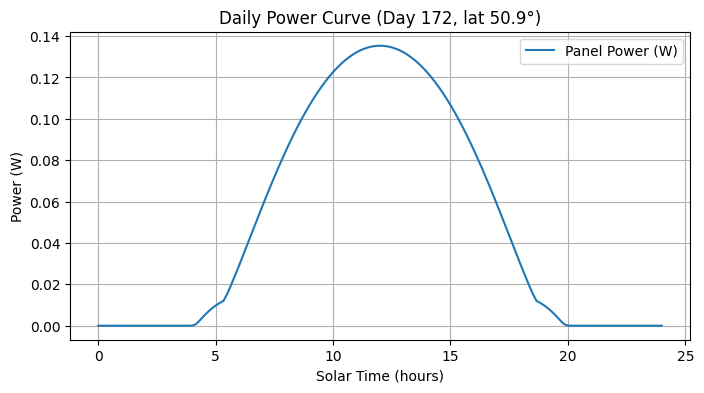

In [65]:
# Example: Brussels, June 21 (day 172)
plot_daily_curve(n=172, latitude=50.9, tilt=30, azimuth=0, area=area, eta_ref=eta_ref)

In [66]:
def plot_week_curve(start_day, latitude, tilt=30, azimuth=0, area=1.6, days=7, **kwargs):
    hours = np.linspace(0, 24, 145)  # 10-min steps
    plt.figure(figsize=(10,5))

    for d in range(days):
        n = start_day + d
        power = [solar_power_estimate(n, h, latitude, tilt, azimuth, area=area, **kwargs) for h in hours]
        plt.plot(hours, power, label=f"Day {n}")

    plt.title(f"Daily Power Curves for Days {start_day}–{start_day+days-1}")
    plt.xlabel("Solar Time (hours)")
    plt.ylabel("Power (W)")
    plt.legend()
    plt.grid(True)
    plt.show()

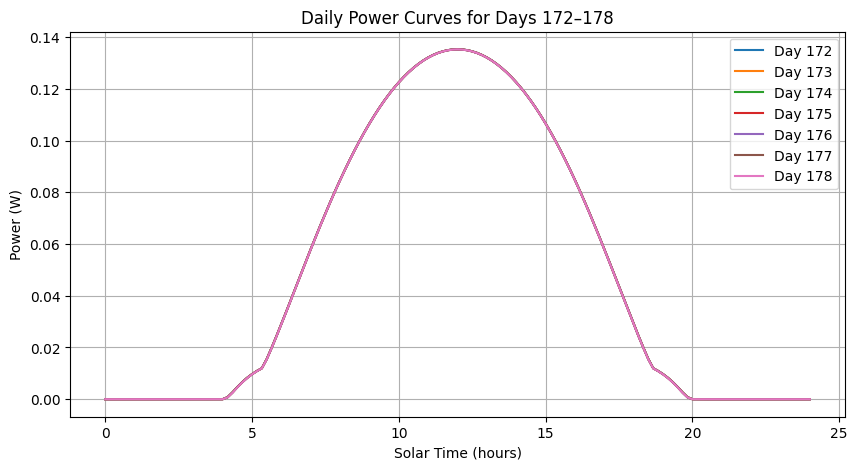

In [67]:
#  Example: Brussels, week starting June 21 (day 172)
plot_week_curve(start_day=172, latitude=50.9, tilt=30, azimuth=0, area=area, days=7, eta_ref=eta_ref)


In [68]:
def plot_year_same_weekday(start_day, latitude, tilt=30, azimuth=0, area=1.6, weeks=52, **kwargs):
    hours = np.linspace(0, 24, 145)  # 10-min steps
    plt.figure(figsize=(12,6))

    for w in range(weeks):
        n = start_day + 7*w
        if n > 365:  # stop if we exceed the year
            break
        power = [solar_power_estimate(n, h, latitude, tilt, azimuth, area=area, **kwargs) for h in hours]
        plt.plot(hours, power, alpha=0.4)  # semi-transparent lines

    plt.title(f"Weekly Power Curves (every 7 days, starting from day {start_day})")
    plt.xlabel("Solar Time (hours)")
    plt.ylabel("Power (W)")
    plt.grid(True)
    plt.savefig("year_same_weekday.pdf")
    plt.show()

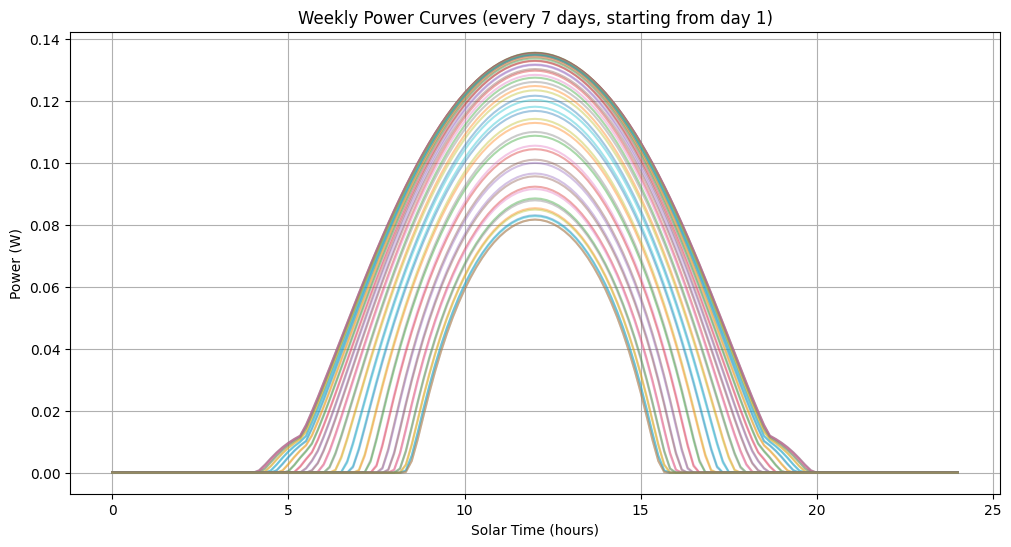

In [69]:
# Example: plot every Monday starting at day 1 (Monday of week 1)
plot_year_same_weekday(start_day=1, latitude=50.9, tilt=30, azimuth=0, area=area, weeks=52, eta_ref=eta_ref)

In [70]:
def solar_day_curve(n, hours, latitude, tilt, azimuth, **kwargs):
    return [solar_power_estimate(n, h, latitude, tilt, azimuth, **kwargs) for h in hours]

In [71]:
def solar_day_curve_with_weather(n, hours, latitude, tilt, azimuth, area=1.6, **kwargs):
    base_curve = [solar_power_estimate(n, h, latitude, tilt, azimuth, area=area, **kwargs) for h in hours]

    # assign a weather state for this day
    state = day_weather_state()
    factor = weather_factor(state)

    return [p * factor for p in base_curve], state


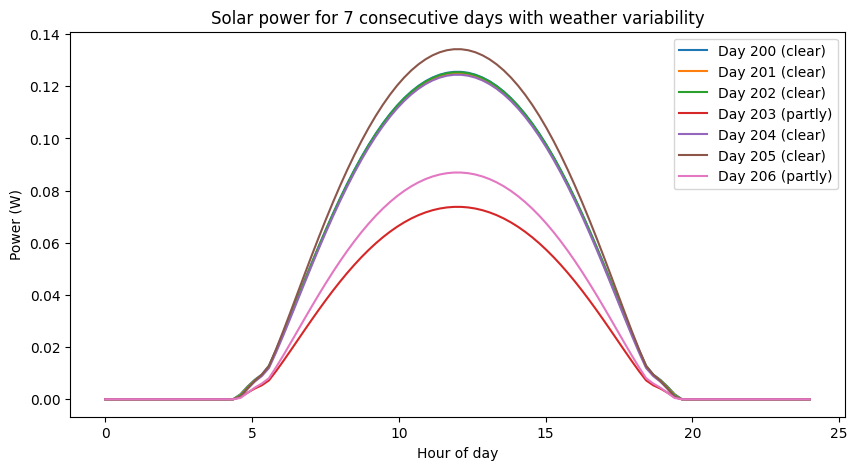

In [75]:
latitude, tilt, azimuth = 50, 30, 0   # example
hours = np.linspace(0, 24, 100)

start_day = 200  # e.g., day of year

plt.figure(figsize=(10,5))

for d in range(7):
    n = start_day + d
    curve, state = solar_day_curve_with_weather(n, hours, latitude, tilt, azimuth, area=area, eta_ref=eta_ref)
    plt.plot(hours, curve, label=f"Day {n} ({state})")

plt.xlabel("Hour of day")
plt.ylabel("Power (W)")
plt.title("Solar power for 7 consecutive days with weather variability")
plt.legend()
plt.savefig("weekly_power_with_weather.pdf")
plt.show()